In [1]:
!tree ../dataset

../dataset
├── en_espanol
│   ├── docx2txt.py
│   ├── Второй_жанр_исходная.txt
│   └── Первый_жанр_исходная.txt
├── Второй_жанр_исходная.txt
├── Первый_жанр_исходная.txt
├── Сокращение по частям речи
│   ├── 1.Первый жанр исходная выборка.txt
│   ├── 2.Первый жанр без клауз, включающих наречия.txt
│   ├── 3.Первый жанр без клауз, включающих глаголы.txt
│   ├── 4. Первый жанр без клауз, включающих глаголы и наречия.txt
│   ├── Без прилагательных второй жанр.txt
│   ├── Без прилагательных первый жанр.txt
│   └── Случайные выборки.txt
└── сокращение по частотности
    ├── 1а_ без сокращений.txt
    ├── 1б_Изъяты лексемы с частотой выше 100.txt
    ├── 1в_Изъяты лексемы с частотой выше 49.txt
    ├── 1г_Изъяты лексемы с частотой выше 29.txt
    ├── 1д_Изъяты лексемы с частотой выше 9.txt
    ├── 2а_ без сокращений.txt
    ├── 2б_Изъяты лексемы с частотой выше 100.txt
    ├── 2в_Изъяты лексемы с частотой выше 49.txt
    ├── 2г_Изъяты лексемы с частотой выше 29.txt
    └── 2д_Изъяты лексемы 

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from isanlp import PipelineCommon
from isanlp.simple_text_preprocessor import SimpleTextPreprocessor
from isanlp.processor_razdel import ProcessorRazdel
import re
import razdel 
from isanlp.pipeline_common import PipelineCommon
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import razdel

import numpy as np
from tqdm import tqdm

import gc
#task
    #compactar el codigo y ponerlo en un loop
    #implementacion de ppl

/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-23 14:10:01.857040: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def cargar_datos(archivo, etiqueta):
    with open(archivo, 'r', encoding='utf-8') as f:
        textos = f.readlines()
    return [(texto.strip(), etiqueta) for texto in textos]


def clean_split_data(datos):
    """
    Limpia los datos eliminando corchetes y los divide en oraciones.
    tambien elimina las oraciones muy puquenas
    
    Args:
        datos (list): Lista de tuplas (texto, etiqueta) donde texto es una cadena y etiqueta un entero.
    
    Returns:
        list: Lista de tuplas (oración, etiqueta) procesadas.
    """
    min_length_threshold = 6
    datos_procesados = [
        (oracion.text, etiqueta)
        for texto, etiqueta in datos
        for oracion in razdel.sentenize(re.sub(r'\[.*?\]', '', texto).strip())
        if len(tokenizer.encode(oracion.text, truncation=False)) >= min_length_threshold
    ]
    
    return datos_procesados



def tokenize_data(df):
    """
    Tokeniza los textos usando BERT.

    Args:
        df (pd.DataFrame): DataFrame con columnas "text" y "label".

    Returns:
        tuple: Encodings y etiquetas como tensores.
    """
    encodings = tokenizer(
        df["text"].tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    labels = torch.tensor(df["label"].values)
    return encodings, labels

# Dataset personalizado
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item
    
    # Tokenización
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
max_length = 128  # Ajustado para eficiencia (puedes analizar tus datos y modificarlo)
#Longitud promedio de tokens: 27.77
#Longitud máxima de tokens: 192
#Longitud mínima de tokens: 2


# Función de entrenamiento
def train_model(model, train_loader, optimizer, loss_fn, device, epochs=3):
    """
    Entrena el modelo BERT.

    Args:
        model: Modelo BERT cargado.
        train_loader: DataLoader con datos de entrenamiento.
        optimizer: Optimizador (AdamW).
        loss_fn: Función de pérdida (CrossEntropyLoss).
        device: Dispositivo (CPU o GPU).
        epochs (int): Número de épocas.
    """
    for epoch in range(epochs):
        model.train()
        loop = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
        for batch in loop:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
        # Liberar memoria después de cada época
        torch.cuda.empty_cache()
        gc.collect()

# Función de evaluación
def evaluate_model(model, test_loader, device):
    """
    Evalúa el modelo en el conjunto de prueba.

    Args:
        model: Modelo BERT entrenado.
        test_loader: DataLoader con datos de prueba.
        device: Dispositivo (CPU o GPU).

    Returns:
        dict: Métricas de evaluación (precisión y reporte completo).
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    report = classification_report(all_labels, all_preds, target_names=["Género 1", "Género 2"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return {"accuracy": accuracy, "report": report, "conf_matrix": conf_matrix}


def display_results(results):
    """
    Muestra los resultados de la evaluación del modelo.
    
    Args:
        results (dict): Diccionario con accuracy, report y conf_matrix.
    """
    # Mostrar precisión y reporte de clasificación
    print(f'Precisión en el conjunto de prueba: {results["accuracy"]:.2%}')
    print("\nReporte de clasificación:\n", results["report"])
    
    # Generar y mostrar mapa de calor de la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(results["conf_matrix"], annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Género 1", "Género 2"], 
                yticklabels=["Género 1", "Género 2"])
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/workspace/notebooks/Carlos/fine_tunig_project/mi_entorno/lib/python3.8/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model fr

Precisión en el conjunto de prueba: 100.00%

Reporte de clasificación:
               precision    recall  f1-score   support

    Género 1       1.00      1.00      1.00       114
    Género 2       1.00      1.00      1.00        77

    accuracy                           1.00       191
   macro avg       1.00      1.00      1.00       191
weighted avg       1.00      1.00      1.00       191



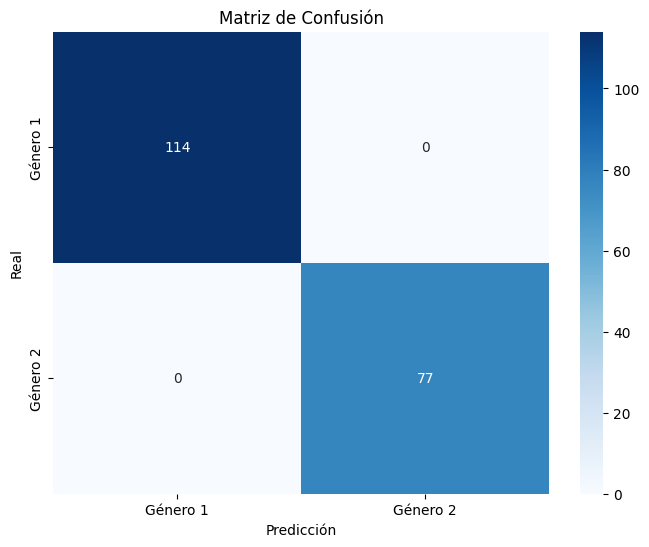

In [4]:

#cargar datos
datos_genero1 = cargar_datos('../dataset/Первый_жанр_исходная.txt', 0)  # Etiqueta 0
datos_genero2 = cargar_datos('../dataset/Второй_жанр_исходная.txt', 1)  # Etiqueta 1
datos = datos_genero1 + datos_genero2


# Creación del DataFrame y división en train/test
#mejora la presicion, elimina ruido
df = pd.DataFrame(clean_split_data(datos), columns=["text", "label"])

#deleteing the min tokens
#min_length_threshold = 6
#df_filtered = df[df["text"].apply(lambda x: len(tokenizer.encode(x, truncation=False)) >= min_length_threshold)]
#print(f"Filtrados {len(df) - len(df_filtered)} textos con menos de {min_length_threshold} tokens.")
#df = df_filtered

#split y guardado
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

#tokenizacion
train_encodings, train_labels = tokenize_data(train_data)
test_encodings, test_labels = tokenize_data(test_data)


# Crear datasets y dataloaders
train_dataset = TextDataset(train_encodings, train_labels)
test_dataset = TextDataset(test_encodings, test_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# parametros del model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('DeepPavlov/rubert-base-cased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()


# Entrenamiento y evaluación
train_model(model, train_loader, optimizer, loss_fn, device, epochs=3)
results = evaluate_model(model, test_loader, device)

#mostrar resultdos
display_results(results)

